# Extracting Semantic and Gesture Representations

This notebook walks you through:

1. **Extracting sentence‑level semantic embeddings** (Dutch BERT).  
2. **Extracting gesture embeddings** with a self‑supervised skeleton‑semantic model.  
3. **Analysing gesture‑gesture similarity**: this will be based on the similarity analysis provided in the paper by Ghaleb et al. (2024)‑ICMI: **Learning Co-Speech Gesture Representations in Dialogue through Contrastive Learning: An Intrinsic Evaluation**. It uses cosine similarity between learned embeddings to evaluate the similarity of gestures based on their semantic content and form features. It follows the intrinsic‑evaluation recipe described in the paper, where cosine similarity between learned embeddings correlated positively with the number of shared form features (ρ≈0.31).


## Table of Contents  
- [0 Setup](#0)  
- [1 Data & Preliminaries](#1)  
- [2 Sentence Embeddings](#2)  
- [3 Gesture Embeddings](#3)  
- [4 Gesture‑Only Similarity](#4)  
- [5 Dialogue‑Level Analyses](#5)  
- [6 Conclusion](#6)  


## 0 <a name='0'></a>Setup
Import common libraries.

In [1]:
import os, numpy as np, pandas as pd, torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from model.skeleton_speech_models import GSSModel
from data.read_process_poses import load_keypoints_dict
from dialog_utils.prepare_gesture_referents_dataset import get_detailed_gestures
from object_retrieval_pair import manual_implementation_object_retrieval

import itertools
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

pd.set_option('display.precision', 2)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


In [2]:
# set the colors and seaborn style
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='Paired', font_scale=1.2)

## 1 <a name='1'></a>Data & Preliminaries
We first define helper functions to obtain mean‑pooled sentence vectors from Dutch BERT.

In [3]:
def mean_pooling(out, mask):
    tok_emb = out[0]
    mask_exp = mask.unsqueeze(-1).expand(tok_emb.size()).float()
    summed = (tok_emb * mask_exp).sum(1)
    denom = mask_exp.sum(1).clamp(min=1e-9)
    return summed / denom

def get_sentence_emb(sentences, model, tok):
    enc = tok(sentences, padding=True, truncation=True, return_tensors='pt').to(DEVICE)
    with torch.no_grad():
        out = model(**enc)
    return mean_pooling(out, enc['attention_mask'])

def load_text_model():
    tok = AutoTokenizer.from_pretrained('GroNLP/bert-base-dutch-cased')
    mdl = AutoModel.from_pretrained('GroNLP/bert-base-dutch-cased',
                                    output_hidden_states=True).to(DEVICE)
    mdl.eval()
    return mdl, tok


### Load the gesture data and the poses. 

The data contains metadata about the gestures, including the speaker, referent, and co-occurring transcriped speech. 

In [4]:
proc_kpts, mir_kpts = load_keypoints_dict()
gestures_information_df = get_detailed_gestures()
# keep iconic strokes only
gestures_information_df = gestures_information_df[gestures_information_df['type'] == 'iconic'].reset_index(drop=True)
# referent cleaning (see paper §3.2)
to_remove = ['-REP', '-rep', '-WF', '-wf', 'ref', 'REF']
gestures_information_df['referent_clean'] = gestures_information_df['referent'].apply(
    lambda x: x if not x.endswith(tuple(to_remove)) else x.split('-')[0])
gestures_information_df = gestures_information_df.assign(
    referent_clean=gestures_information_df['referent_clean'].str.split('+')).explode('referent_clean')
gestures_information_df['referent_clean'] = gestures_information_df['referent_clean'].str.strip().str.replace('-', '0').str.replace("'", '')
gestures_information_df = gestures_information_df[gestures_information_df['referent_clean'] != 'undecided']
gestures_information_df['processed_referent_target_fribble'] = gestures_information_df['referent_clean']
print('Iconic gestures loaded:', len(gestures_information_df))


Iconic gestures loaded: 4637


### 1.2 Let's inspect few rows of the annotated gesture DataFrame. 

In [5]:
gestures_information_df.head(3)  # Display the first 3 rows of the DataFrame

,pair,turn,round,type,is_gesture,from_ts,to_ts,referent,comment,duration,...,pair_speaker,words,lemmas,pos,lemmas_pos,transcriptions,contain_text,segmentation method,referent_clean,processed_referent_target_fribble
0,pair04,0,1,iconic,gesture,4.09,4.50,main,NaN,0.41,...,pair04_B,zeggen dat hoofdplatform,zeggen dat hoofdplatform,VERB SCONJ NOUN,zeggen#VERB dat#SCONJ hoofdplatform#NOUN,manual,True,manual,main,main
1,pair04,2,1,iconic,gesture,8.46,8.94,09C,NaN,0.48,...,pair04_B,steeksel aan de linkerkant,steeksel aan de linkerkant,NOUN ADP DET NOUN,steeksel#NOUN aan#ADP de#DET linkerkant#NOUN,manual,True,manual,09C,09C
2,pair04,4,1,iconic,gesture,11.78,12.20,09C,NaN,0.42,...,pair04_B,is een rond uitsteeksel,zijn een rond uitsteeksel,AUX DET ADP NOUN,zijn#AUX een#DET rond#ADP uitsteeksel#NOUN,manual,True,manual,09C,09C


## 2 <a name='2'></a>Sentence Embeddings  

Let's first start with loading the Dutch BERT model and defining a function to obtain mean‑pooled sentence vectors.

Then, we demonstrate how to encode two Dutch sentences using the model.


In [6]:
text_model, tokenizer = load_text_model()
TEST = ['Een korte zin.', 'Nog een voorbeeld.']
embs = get_sentence_emb(TEST, text_model, tokenizer).cpu().numpy()
print(embs.shape)  # (2, 768)

Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(2, 768)


In [7]:
# remove any existing column
if 'semantic_embeddings' in gestures_information_df:
    gestures_information_df.drop(columns='semantic_embeddings', inplace=True)
# compute embeddings with a list and assign once
embeddings = []
for utt in tqdm(gestures_information_df['processed_utterance'], total=len(gestures_information_df)):
    text = "" if pd.isna(utt) else utt.strip()
    emb = get_sentence_emb([text], text_model, tokenizer).squeeze(0).cpu().numpy()
    embeddings.append(emb)

gestures_information_df['semantic_embeddings'] = embeddings


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 4637/4637 [02:17<00:00, 33.69it/s]


## 3 <a name='3'></a> Gesture Embeddings




We use the `Multimodal-X` encoders from another paper, **I see what you mean: Co-Speech Gestures for Reference Resolution in Multimodal Dialogue** (Ghaleb et al., 2025), to extract gesture embeddings. The models are trained on skeleton and semantic features, and we use it to obtain gesture embeddings.

In [8]:
def load_pretrained(params):
    path = params['model_weights']
    params = params.copy(); _ = params.pop('model_weights')
    mdl = GSSModel(**params)
    w = torch.load(path, map_location='cpu')
    for k in mdl.state_dict():
        mdl.state_dict()[k].copy_(w['state_dict']['model.'+k])
    return mdl.to(DEVICE).eval()

MODELS = {
    'multimodal-x': {
        'modalities':['skeleton','semantic'],
        'hidden_dim':256,'cross_modal':True,'attentive_pooling':False,
        'model_weights':'pretrained_models/multimodal-x_skeleton_text_correlation=0.30.ckpt'}
}
model_key = 'multimodal-x'
mdl = load_pretrained(MODELS[model_key])


### Extract embeddings for the full dataset

In [9]:
gestures_information_df = manual_implementation_object_retrieval(
        mdl, proc_kpts, mir_kpts, 'jointsformer',
        gestures_and_speech_info=gestures_information_df,
        modalities=MODELS[model_key]['modalities'],
        audio_dict={}, model_type=model_key)
gestures_information_df.rename(columns={'transformer_features': model_key}, inplace=True)
print('Embedding vector length:', len(gestures_information_df[model_key].iloc[0]))

  0%|          | 0/4637 [00:00<?, ?it/s]/opt/anaconda3/envs/test2/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2714: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
100%|██████████| 4637/4637 [07:12<00:00, 10.72it/s]

Embedding vector length: 256


## 6  Intrinsic Gesture‑Similarity Evaluation <a name="Similarity"></a>

Following Section 5 of the paper, we compare cosine similarity
scores across logically defined *pair types*:

| Pair Type | Same Speaker | Same Referent | Same Dialogue |
|-----------|--------------|---------------|---------------|
| **same-ref & same-speaker** | ✅ | ✅ | ✅ |
| **same-ref & diff-speaker** | ❌ | ✅ | ✅ |
| **diff-ref & same-speaker** | ✅ | ❌ | ✅ |
| **diff-ref & diff-speaker** | ❌ | ❌ | ✅ |
| **Cross‑Dialogue & same-ref** | ❌ | ✅ | ❌ |
| **Cross‑Dialogue & diff-ref** | ❌ | ❌ | ❌ |


In [10]:
def compute_similarity_for_pairs(pairs, similarities):
    return [similarities[i, j] for i, j in pairs]

def compare_similarity_for_diff_pairs(features, gestures_information_df, embeddings_type='gesture'):
    pairs = gestures_information_df['pair'].to_numpy()
    speakers = gestures_information_df['speaker'].to_numpy()
    referents = gestures_information_df['processed_referent_target_fribble'].to_numpy()
    pair_speakers = gestures_information_df['pair_speaker'].to_numpy()

    indices = range(len(gestures_information_df))

    # Define pair types
    same_pair_referent_speaker = []
    same_referent_same_pair_different_speaker = []
    same_referent_different_pair = []
    same_pair_different_referent = []
    different_pair_different_referent = []
    same_pair_same_speaker_different_referent = []

    for index_i, index_j in itertools.combinations(indices, 2):
        if index_i == index_j:
            continue
        if pairs[index_i] == pairs[index_j] and speakers[index_i] == speakers[index_j] and referents[index_i] == referents[index_j]:
            same_pair_referent_speaker.append((index_i, index_j))
        if pairs[index_i] == pairs[index_j] and speakers[index_i] != speakers[index_j] and referents[index_i] == referents[index_j]:
            same_referent_same_pair_different_speaker.append((index_i, index_j))
        if pairs[index_i] != pairs[index_j] and referents[index_i] == referents[index_j]:
            same_referent_different_pair.append((index_i, index_j))
        if pairs[index_i] == pairs[index_j] and referents[index_i] != referents[index_j] and pair_speakers[index_i] != pair_speakers[index_j]:
            same_pair_different_referent.append((index_i, index_j))
        if pairs[index_i] != pairs[index_j] and referents[index_i] != referents[index_j]:
            different_pair_different_referent.append((index_i, index_j))
        if pair_speakers[index_i] == pair_speakers[index_j] and referents[index_i] != referents[index_j]:
            same_pair_same_speaker_different_referent.append((index_i, index_j))
    
    # Calculate similarities
    similarities = cosine_similarity(features)
    same_pair_referent_speaker_similarities = compute_similarity_for_pairs(same_pair_referent_speaker, similarities)
    same_referent_same_pair_different_speaker_similarities = compute_similarity_for_pairs(same_referent_same_pair_different_speaker, similarities)
    same_referent_different_pair_similarities = compute_similarity_for_pairs(same_referent_different_pair, similarities)
    same_pair_different_referent_similarities = compute_similarity_for_pairs(same_pair_different_referent, similarities)
    different_pair_different_referent_similarities = compute_similarity_for_pairs(different_pair_different_referent, similarities)
    same_pair_same_speaker_different_referent_similarities = compute_similarity_for_pairs(same_pair_same_speaker_different_referent, similarities)
    
    similarities_df = pd.DataFrame({'similarity': same_pair_referent_speaker_similarities +same_pair_same_speaker_different_referent_similarities+ same_referent_same_pair_different_speaker_similarities + same_referent_different_pair_similarities + same_pair_different_referent_similarities + different_pair_different_referent_similarities, 'pair_type': ['Same P&&S'] * len(same_pair_referent_speaker_similarities) + ['Same P&S - Diff R'] * len(same_pair_same_speaker_different_referent_similarities) +
                                    ['Same R &P - diff S'] * len(same_referent_same_pair_different_speaker_similarities) + ['Same R - Diff P&S'] * len(same_referent_different_pair_similarities) + ['Same P - Diff R&S'] * len(same_pair_different_referent_similarities) + ['Diff P&R&S'] * len(different_pair_different_referent_similarities)})
  
    return similarities_df
   

## 4 <a name='4'></a>Gesture‑Only Similarity
Following the paper (§5.1), we compute cosine similarity and compare positive vs negative gesture pairs (same vs different referent & speaker).

Pos mean=0.27  Neg mean=0.13


Text(0.5, 1.0, 'Gesture similarity (cosine) for same/different referent pairs of the same speaker')

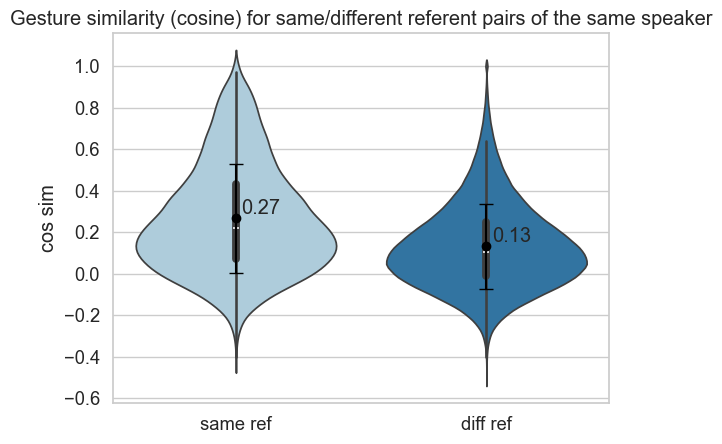

In [11]:

from sklearn.metrics.pairwise import cosine_similarity
import itertools, random, seaborn as sns, matplotlib.pyplot as plt

# build similarity matrix
features = np.vstack(gestures_information_df[model_key].to_numpy())
sim_mat = cosine_similarity(features)

# positive / negative pairs (same speaker + same referent)
positive_pairs, negative_pairs = [], []
pairs = gestures_information_df['pair'].to_numpy()
speakers = gestures_information_df['speaker'].to_numpy()
referents = gestures_information_df['processed_referent_target_fribble'].to_numpy()
for i, j in itertools.combinations(range(len(gestures_information_df)), 2):
    if speakers[i] == speakers[j] and pairs[i] == pairs[j]:
        # same speaker + same pair
        if referents[i] == referents[j]:
            positive_pairs.append((i,j))
        else:
            negative_pairs.append((i,j))
def score(pairs):
    return [sim_mat[i,j] for i,j in pairs]
pos, neg = score(positive_pairs), score(negative_pairs)
print(f'Pos mean={np.mean(pos):.2f}  Neg mean={np.mean(neg):.2f}')
sns.violinplot(data=[pos,neg]); plt.xticks([0,1],['same ref','diff ref']); plt.ylabel('cos sim');
# plot the mean for each pair type
plt.errorbar([0,1], [np.mean(pos), np.mean(neg)], yerr=[np.std(pos), np.std(neg)],
             fmt='o', color='black', capsize=5, label='mean ± std')
# annotate the means
plt.text(0+0.1, np.mean(pos) + 0.00, f'{np.mean(pos):.2f}', ha='center', va='bottom')
plt.text(1+0.1, np.mean(neg) + 0.00, f'{np.mean(neg):.2f}', ha='center', va='bottom')
plt.title('Gesture similarity (cosine) for same/different referent pairs of the same speaker')

## 5 <a name='5'></a>Dialogue‑Level Analyses
Replicating the **speaker ✕ referent** effects reported in §5.2

In [12]:
similarities_df = compare_similarity_for_diff_pairs(features, gestures_information_df, embeddings_type='gesture')

In [13]:
similarities_df['pair_type'].value_counts().to_dict()

{'Diff P&R&S': 9693654,
 'Same P&S - Diff R': 436495,
 'Same P - Diff R&S': 345797,
 'Same R - Diff P&S': 247392,
 'Same P&&S': 14437,
 'Same R &P - diff S': 10791}

/var/folders/w_/bf2mvf1d6wn_jx4fx0k7bs1m0000gp/T/ipykernel_65923/1287072405.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dialogue_df['pair_type'] = pd.Categorical(dialogue_df['pair_type'], dialogue_pair_types)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: p <= 5.00e-02

Same P&&S vs. Same P&S - Diff R: t-test independent samples with Bonferroni correction, P_val:0.000e+00 t=7.698e+01
Same R &P - diff S vs. Same P - Diff R&S: t-test independent samples with Bonferroni correction, P_val:3.882e-116 t=2.298e+01
Same P&S - Diff R vs. Same R &P - diff S: t-test independent samples with Bonferroni correction, P_val:6.814e-98 t=2.107e+01
Same P&S - Diff R vs. Same P - Diff R&S: t-test independent samples with Bonferroni correction, P_val:0.000e+00 t=1.834e+02


([<matplotlib.axis.XTick at 0x17c3a83d0>,
 [Text(0, 0, 'same-ref\nsame-speaker'),
  Text(1, 0, 'diff-ref\nsame-speaker'),
  Text(2, 0, 'same-ref\ndiff-speaker'),
  Text(3, 0, 'diff-ref\ndiff-speaker')])

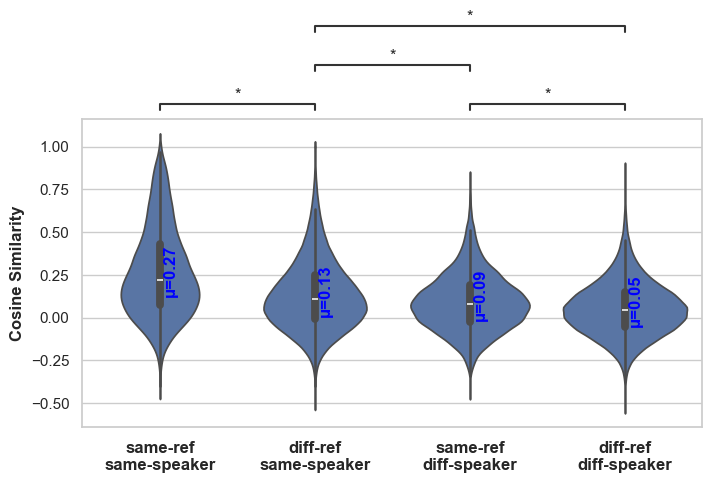

In [14]:
# features which involve cross-speakers
dialogue_pair_types = ['Same P&&S', 'Same P&S - Diff R', 'Same R &P - diff S', 'Same P - Diff R&S']
pairs_mapping = {'Same P&&S': 'same-ref\nsame-speaker', 'Same P&S - Diff R': 'diff-ref\nsame-speaker', 'Same R &P - diff S': 'same-ref\ndiff-speaker', 'Same P - Diff R&S': 'diff-ref\ndiff-speaker'}
# sort pairs in the order of the dialogue_pair_types
dialogue_df = similarities_df[similarities_df['pair_type'].isin(dialogue_pair_types)]  
dialogue_df['pair_type'] = pd.Categorical(dialogue_df['pair_type'], dialogue_pair_types)


# plot the distribution of the cross-speakers pair types
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.violinplot(x='pair_type', y='similarity', data=dialogue_df)
# use the Annotator class to annotate the box plot
x = 'pair_type'
y = 'similarity'
order = dialogue_pair_types
pairs = [('Same P&&S', 'Same P&S - Diff R'), ('Same R &P - diff S', 'Same P - Diff R&S'), ('Same P&S - Diff R', 'Same R &P - diff S'), ('Same P&S - Diff R', 'Same P - Diff R&S')]
ax = plt.gca()
annotator = Annotator(ax, pairs, data=dialogue_df, x=x, y=y, order=order)
annotator.configure(test='t-test_ind', text_format='star', loc='outside', comparisons_correction="Bonferroni", hide_non_significant=True, pvalue_thresholds=[[0.05, "*"], [1, "ns"]])
annotator.apply_and_annotate()
# rename the x-axis label
plt.xlabel('')
plt.ylabel('Cosine Similarity', fontdict={'weight': 'bold', 'size': 12})
# rename the x-ticks 
# annotate the box plot with the mean similarity
ax = plt.gca()
for i, order_type in enumerate(dialogue_pair_types):
    median = dialogue_df[dialogue_df['pair_type'] == order_type]['similarity'].median()
    mean = dialogue_df[dialogue_df['pair_type'] == order_type]['similarity'].mean()
    ax.text(i+0.07, median-0.1, f'μ={mean:.2f}', ha='center', va='bottom', fontsize=12, fontdict={'weight': 'bold'}, color='blue', rotation=90)
plt.xticks(range(len(dialogue_pair_types)), [pairs_mapping[pair_type] for pair_type in dialogue_pair_types], rotation=0, fontdict={'weight': 'bold', 'size': 12})

## 6 <a name='6'></a>Cross Dialouges Analyses
Replicating the **Referent vs. Interaction Driven Similarity** where we compare the similarity of gestures across dialogues, as described in §5.2.2 of the paper.

/var/folders/w_/bf2mvf1d6wn_jx4fx0k7bs1m0000gp/T/ipykernel_65923/3988791921.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_speakers_df['pair_type'] = pd.Categorical(cross_speakers_df['pair_type'], cross_spealers_pair_types)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: p <= 5.00e-02

Same R &P - diff S vs. Same R - Diff P&S: t-test independent samples with Bonferroni correction, P_val:1.442e-08 t=5.993e+00
Same P - Diff R&S vs. Diff P&R&S: t-test independent samples with Bonferroni correction, P_val:0.000e+00 t=4.055e+01
Same R - Diff P&S vs. Same P - Diff R&S: t-test independent samples with Bonferroni correction, P_val:0.000e+00 t=6.049e+01
Same R - Diff P&S vs. Same P - Diff R&S: t-test independent samples with Bonferroni correction, P_val:0.000e+00 t=6.049e+01
Same R - Diff P&S vs. Same P - Diff R&S: t-test independent samples with Bonferroni correction, P_val:0.000e+00 t=6.049e+01
Same R &P - diff S vs. Diff P&R&S: t-test independent samples with Bonferroni correction, P_val:8.329e-217 t=3.149e+01
Same R &P - diff S vs. Diff P&R&S: t-test independent samples with Bonferroni correction, P_val:8.329e-217 t=3.149e+01


([<matplotlib.axis.XTick at 0x433e6c730>,
 [Text(0, 0, 'same-ref\nsame-dialogue'),
  Text(1, 0, 'same-ref\ndiff-dialogue'),
  Text(2, 0, 'diff-referent\nsame-dialogue'),
  Text(3, 0, 'diff-ref\ndiff-dialogue')])

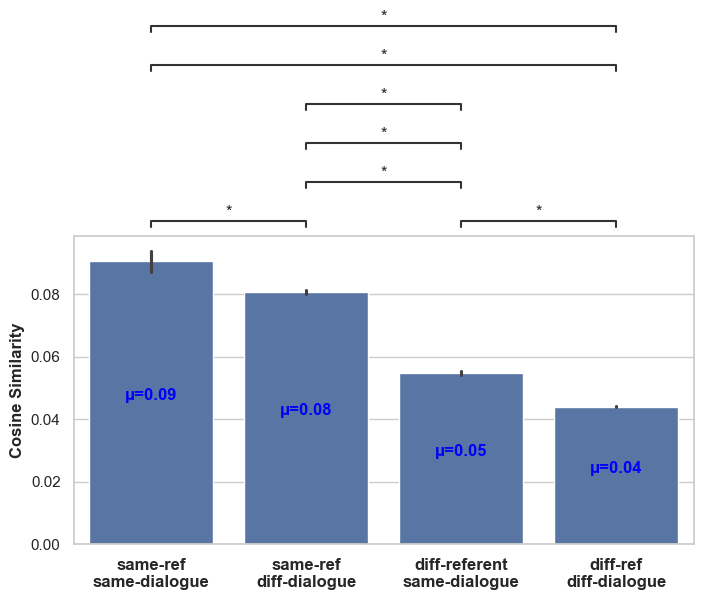

In [15]:
# features which involve cross-speakers and cross-dialogues
cross_spealers_pair_types = ['Same R &P - diff S', 'Same R - Diff P&S', 'Same P - Diff R&S', 'Diff P&R&S']
pairs_mapping = {'Same R &P - diff S': 'same-ref\nsame-dialogue', 'Same R - Diff P&S': 'same-ref\ndiff-dialogue', 'Same P - Diff R&S': 'diff-referent\nsame-dialogue', 'Diff P&R&S': 'diff-ref\ndiff-dialogue'}

# pairs_mapping = {'Same P&&S': 'Same-referent\nsame-speaker', 'Same P&S - Diff R': 'Different-referent\nsame-speaker', 'Same R &P - diff S': 'Same-referent\ndifferent-speaker', 'Same P - Diff R&S': 'Different-referent\ndifferent-speaker'}


# sort pairs in the order of the dialogue_pair_types
cross_speakers_df = similarities_df[similarities_df['pair_type'].isin(cross_spealers_pair_types)]  
cross_speakers_df['pair_type'] = pd.Categorical(cross_speakers_df['pair_type'], cross_spealers_pair_types)

# plot the distribution of the cross-speakers pair types
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.barplot(x='pair_type', y='similarity', data=cross_speakers_df)
# use the Annotator class to annotate the box plot
x = 'pair_type'
y = 'similarity'
order = cross_spealers_pair_types
pairs = [('Same R &P - diff S', 'Same R - Diff P&S'), ('Same P - Diff R&S', 'Diff P&R&S'), ('Same R - Diff P&S', 'Same P - Diff R&S'), ('Same R &P - diff S', 'Diff P&R&S'), ('Same R - Diff P&S', 'Same P - Diff R&S'), ('Same R &P - diff S', 'Diff P&R&S'), ('Same R - Diff P&S', 'Same P - Diff R&S')]
ax = plt.gca()
annotator = Annotator(ax, pairs, data=cross_speakers_df, x=x, y=y, order=order)
annotator.configure(test='t-test_ind', text_format='star', loc='outside', comparisons_correction="Bonferroni", hide_non_significant=True, pvalue_thresholds=[[0.05, "*"], [1, "ns"]])
annotator.apply_and_annotate()
# rename the x-axis label
plt.xlabel('')
plt.ylabel('Cosine Similarity', fontdict={'weight': 'bold', 'size': 12})
# rename the x-ticks 
# annotate the box plot with the mean similarity
ax = plt.gca()
for i, order_type in enumerate(cross_spealers_pair_types):
    mean = cross_speakers_df[cross_speakers_df['pair_type'] == order_type]['similarity'].mean()
    ax.text(i, mean/2, f'μ={mean:.2f}', ha='center', va='bottom', fontsize=12, fontdict={'weight': 'bold'}, color='blue')
plt.xticks(range(len(cross_spealers_pair_types)), [pairs_mapping[pair_type] for pair_type in cross_spealers_pair_types], rotation=0, fontdict={'weight': 'bold', 'size': 12})

## 7 <a name='7'></a>Conclusion  
We reproduced the intrinsic evaluation workflow showing that cosine similarity of contrastively‑learned gesture embeddings:

* rises with the number of shared form features,  
* tracks features related to the semantic content of the gestures, speaker style, and interaction content.